   Year       State  Deaths  Population  Age-adjusted Death Rate  \
0  1999     Alabama   35440     4430141                   1009.3   
1  1999      Alaska    2074      624779                    838.9   
2  1999     Arizona   31796     5023823                    818.4   
3  1999    Arkansas   22012     2651860                    975.3   
4  1999  California  186153    33499204                    802.3   

   Poverty Rate  Income Per Capita  Spending  Median Income  \
0          15.2              23296    3689.0        36251.0   
1           7.6              29941    4076.0        51396.0   
2          12.2              24866    3068.0        36995.0   
3          14.7              21842    3517.0        29682.0   
4          14.0              30529    3436.0        43629.0   

   Proportional Death Rate  
0               799.974538  
1               331.957380  
2               632.904463  
3               830.058902  
4               555.693801  


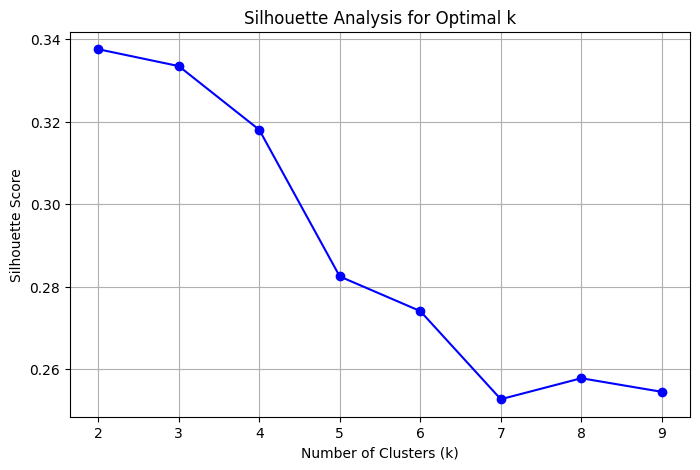

2


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import statsmodels.api as sm

# Load all datasets
file_deaths_population = "../data/processed/States_Deaths_Populations.csv"
file_poverty = "../data/processed/US_Poverty_Rate.csv"
file_income_per_capita = "../data/processed/Personal_Income_Per_Capita.csv"
file_health_care = "../data/processed/Personal_Health_Care_Per_Capita.csv"
file_median_income = "../data/processed/Median_Household_Income.csv"

# Read CSV files
df_deaths_population = pd.read_csv(file_deaths_population)
df_poverty = pd.read_csv(file_poverty)
df_income_per_capita = pd.read_csv(file_income_per_capita)
df_health_care = pd.read_csv(file_health_care)
df_median_income = pd.read_csv(file_median_income)

# Reshape "Income Per Capita" dataset to long format
df_income_per_capita_long = df_income_per_capita.melt(id_vars=["State"], var_name="Year", value_name="Income Per Capita")

# Convert "Year" to integer for consistency
df_income_per_capita_long["Year"] = df_income_per_capita_long["Year"].astype(int)

# Try merging all datasets
df_master = df_deaths_population.merge(df_poverty, on=["State", "Year"], how="left")
df_master = df_master.merge(df_income_per_capita_long, on=["State", "Year"], how="left")
df_master = df_master.merge(df_health_care, on=["State", "Year"], how="left")
df_master = df_master.merge(df_median_income, on=["State", "Year"], how="left")

# Recalculate Proportional Death Rate (deaths per 100,000 population)
df_master["Proportional Death Rate"] = (df_master["Deaths"] / df_master["Population"]) * 100000

print(df_master.head())

# Select relevant features for clustering
clustering_features = df_master[["Age-adjusted Death Rate", "Poverty Rate", "Income Per Capita", "Spending"]]

# Handle missing values by filling with the mean
clustering_features = clustering_features.fillna(clustering_features.mean())

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Define the range of k values to test
k_values = range(2, 10)  # Testing cluster sizes from 2 to 9
silhouette_scores = []

# Iterate over different k values and compute the silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores to find the best k
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker="o", linestyle="-", color="blue")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Optimal k")
plt.grid(True)
plt.show()

# Find the optimal k with the highest silhouette score
optimal_k = k_values[np.argmax(silhouette_scores)]
print(optimal_k)

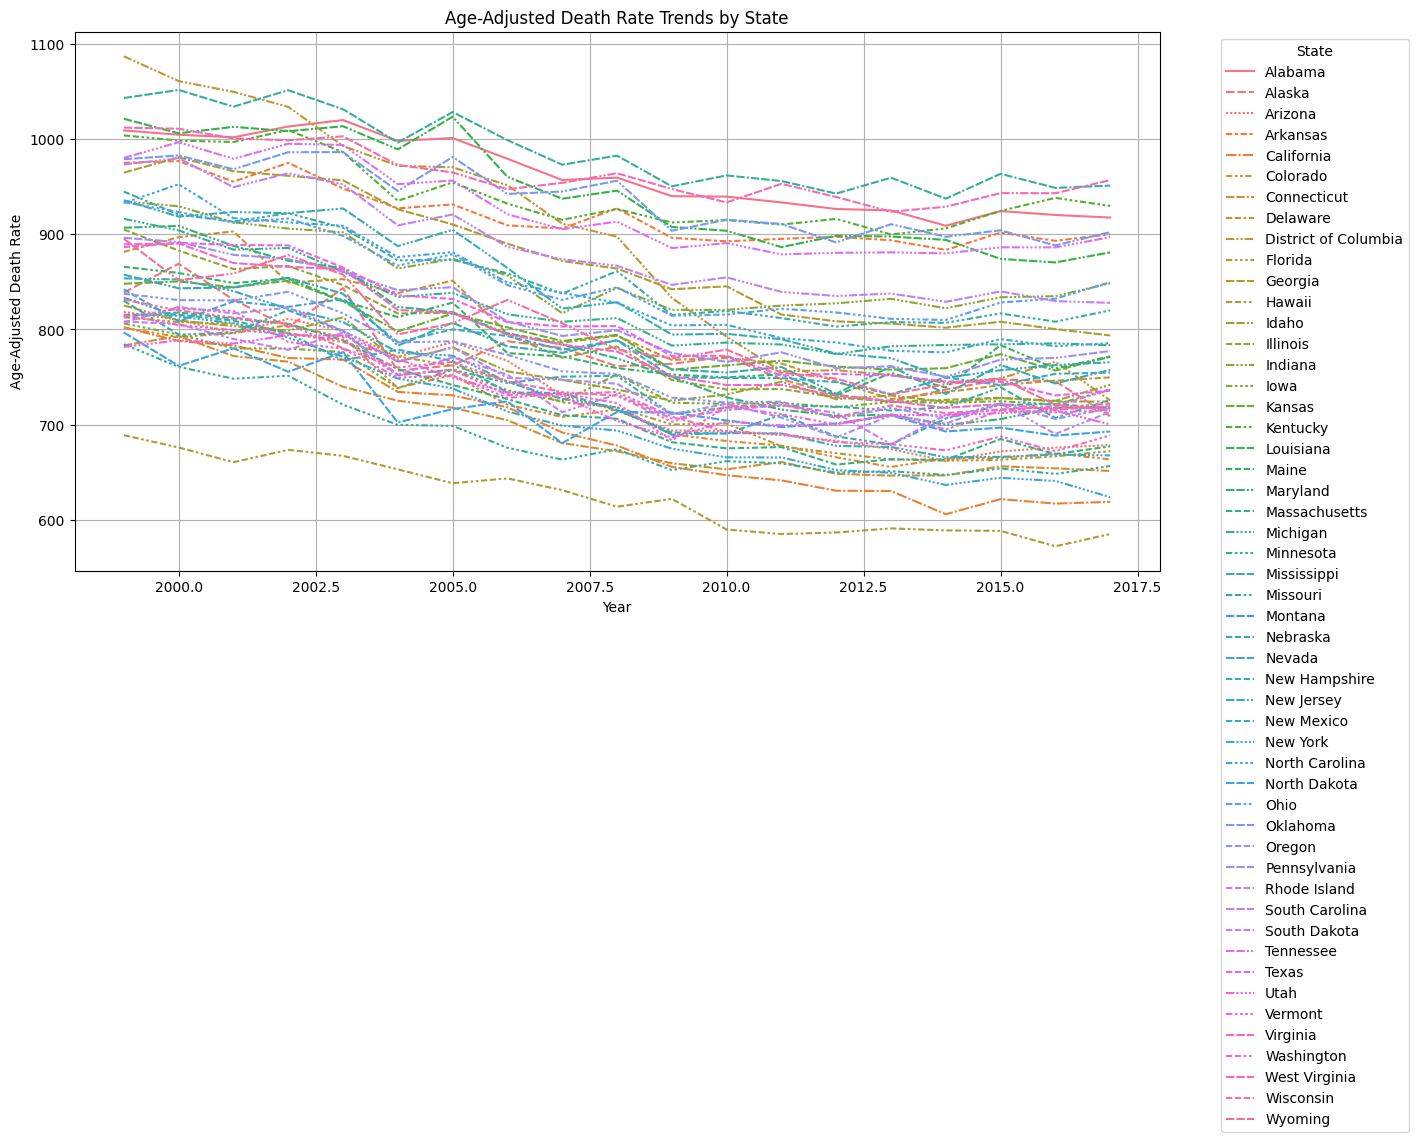

In [13]:
df_aadr = df_master.pivot_table(index="Year", columns="State", values="Age-adjusted Death Rate")

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_aadr)
plt.title("Age-Adjusted Death Rate Trends by State")
plt.xlabel("Year")
plt.ylabel("Age-Adjusted Death Rate")
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.show()

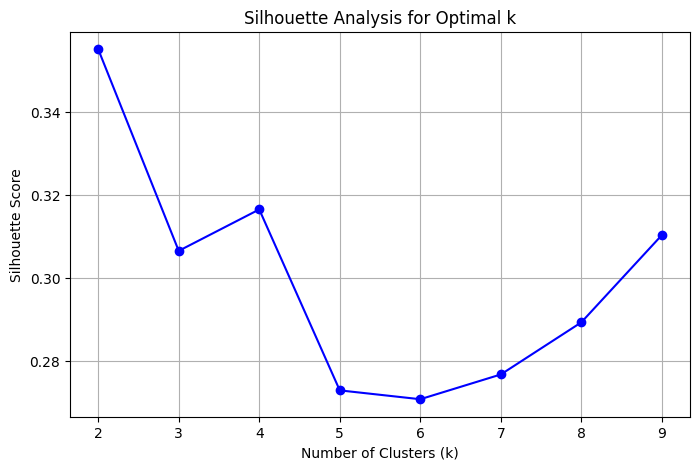

2
         Normalized Income Per Capita  Normalized Spending  \
Cluster                                                      
0                           -0.764881            -0.621001   
1                            0.617898             0.501667   

         Normalized Age-adjusted Death Rate  Normalized Poverty Rate  
Cluster                                                               
0                                  0.708005                 0.662032  
1                                 -0.571952                -0.534813  


<Figure size 1200x600 with 0 Axes>

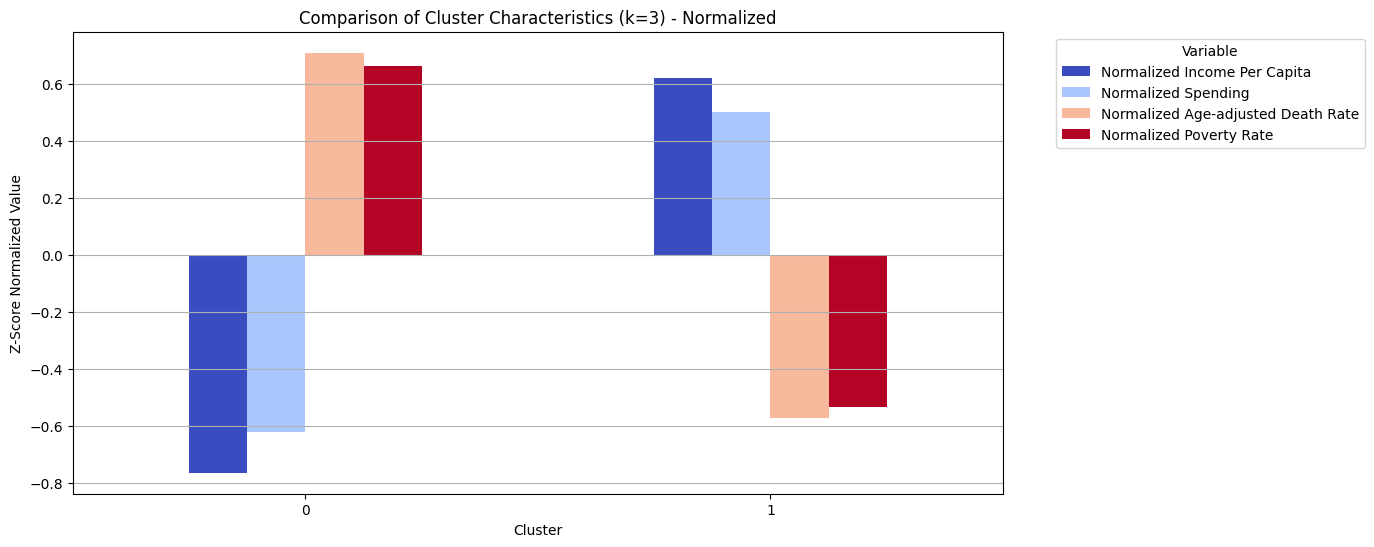

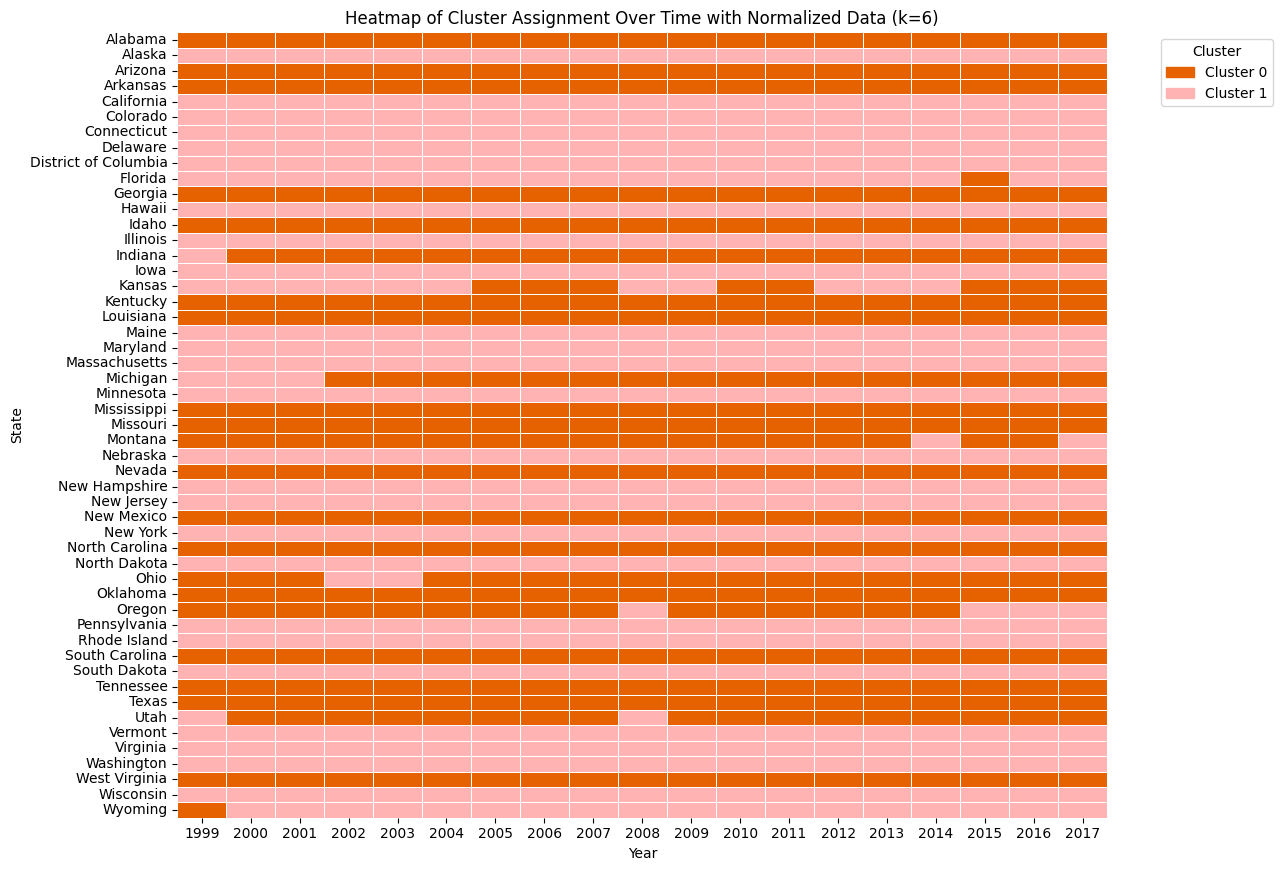

In [16]:
# Normalize selected columns by year
variables_to_normalize = ["Income Per Capita", "Spending", "Age-adjusted Death Rate", "Poverty Rate"]
df_normalized = df_master.copy()

for var in variables_to_normalize:
    df_normalized[f"Normalized {var}"] = df_normalized.groupby("Year")[var].transform(
        lambda x: (x - x.mean()) / x.std()
    )
    
    
# Select the normalized variables for clustering
normalized_features = [
    "Normalized Income Per Capita",
    "Normalized Spending",
    "Normalized Age-adjusted Death Rate",
    "Normalized Poverty Rate",
]
    
scaler = StandardScaler()
scaled_normalized_features = scaler.fit_transform(df_normalized[normalized_features])

# Define the range of k values to test
k_values = range(2, 10)  # Testing cluster sizes from 2 to 9
silhouette_scores = []

# Iterate over different k values and compute the silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_normalized_features)
    silhouette_avg = silhouette_score(scaled_normalized_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores to find the best k
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker="o", linestyle="-", color="blue")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Optimal k")
plt.grid(True)
plt.show()

# Find the optimal k with the highest silhouette score
optimal_k = k_values[np.argmax(silhouette_scores)]
print(optimal_k)

# Re-run K-Means clustering with k=3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_normalized["Cluster"] = kmeans.fit_predict(scaled_normalized_features)


# Display the new cluster characteristics
cluster_characteristics_normalized = df_normalized.groupby("Cluster")[
    normalized_features
].mean()

print(cluster_characteristics_normalized)

# Plot Z-score normalized data
plt.figure(figsize=(12, 6))
cluster_characteristics_normalized.plot(kind="bar", figsize=(12, 6), colormap="coolwarm")
plt.xlabel("Cluster")
plt.ylabel("Z-Score Normalized Value")
plt.title("Comparison of Cluster Characteristics (k=3) - Normalized")
plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

# Create a heatmap to visualize the cluster distribution over time
cluster_heatmap_normalized_data = df_normalized.pivot_table(index="State", columns="Year", values="Cluster")

# Define a discrete colormap for clusters 0, 1
cluster_colors = ["#E66100", "#FFB3B3"]  # Assign colors to clusters
cmap = ListedColormap(cluster_colors)

# Create the heatmap
plt.figure(figsize=(12, len(cluster_heatmap_normalized_data) * 0.2))
ax = sns.heatmap(cluster_heatmap_normalized_data, cmap=cmap, annot=False, linewidths=0.5, cbar=False)

# Create a custom legend
legend_patches = [Patch(color=cluster_colors[i], label=f"Cluster {i}") for i in range(2)]
plt.legend(handles=legend_patches, title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

# Titles and labels
plt.title("Heatmap of Cluster Assignment Over Time with Normalized Data (k=6)")
plt.xlabel("Year")
plt.ylabel("State")

# Show plot
plt.show()

                               OLS Regression Results                              
Dep. Variable:     Age-adjusted Death Rate   R-squared:                       0.521
Model:                                 OLS   Adj. R-squared:                  0.519
Method:                      Least Squares   F-statistic:                     261.7
Date:                     Sun, 09 Feb 2025   Prob (F-statistic):          3.28e-152
Time:                             22:58:14   Log-Likelihood:                -5459.6
No. Observations:                      969   AIC:                         1.093e+04
Df Residuals:                          964   BIC:                         1.095e+04
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

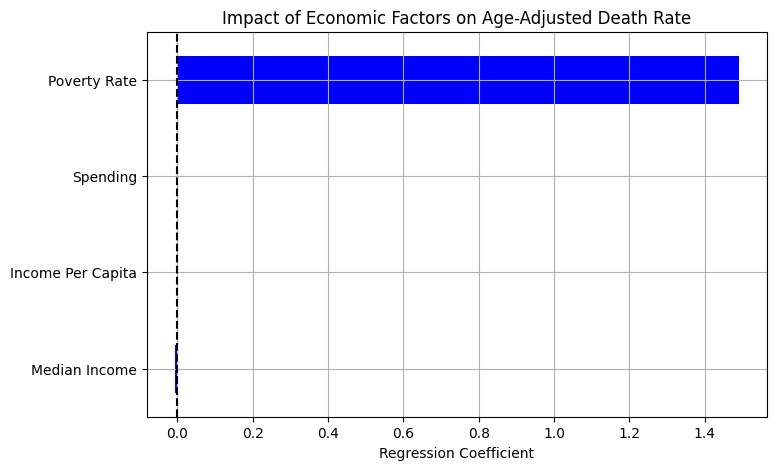

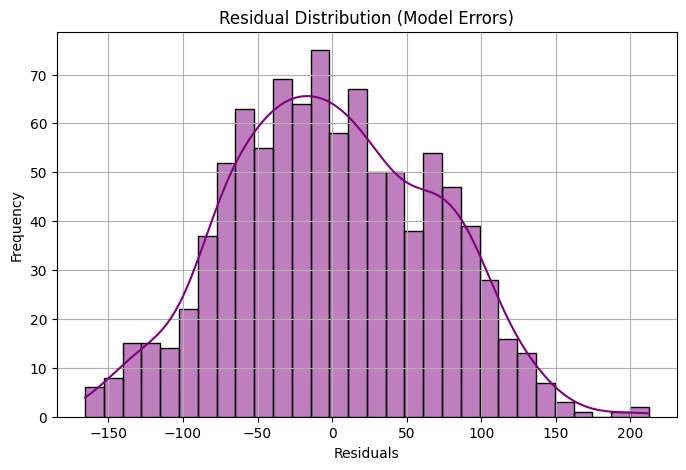

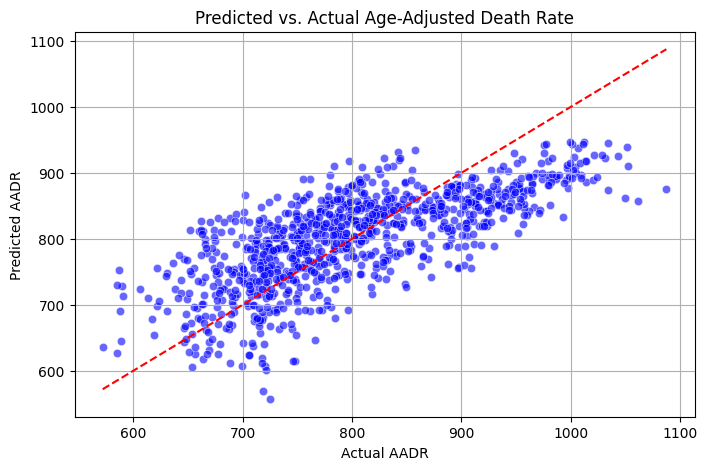

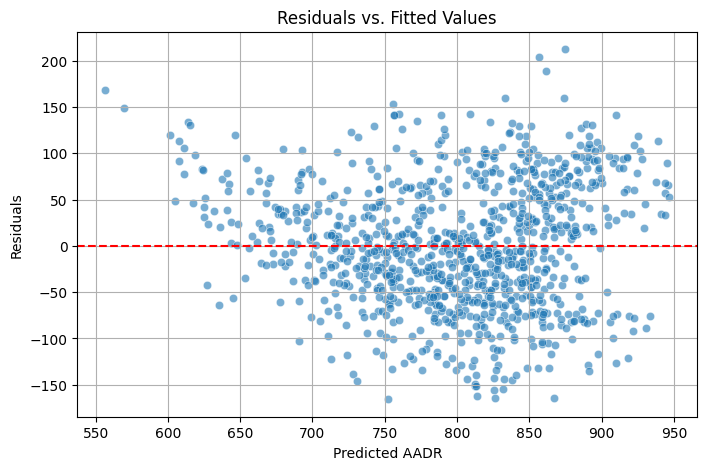

In [17]:
economic_factors = ["Income Per Capita", "Median Income", "Poverty Rate", "Spending"]

# Define independent (X) and dependent (Y) variables
X = df_master[economic_factors]
y = df_master["Age-adjusted Death Rate"]

# Add constant for regression
X = sm.add_constant(X)

# Fit regression model
model = sm.OLS(y, X).fit()
print(model.summary())

# Extract coefficients
coef = model.params[1:]  # Exclude the constant term

# Coefficient Bar Chart
plt.figure(figsize=(8, 5))
coef.sort_values().plot(kind="barh", color="blue")
plt.xlabel("Regression Coefficient")
plt.title("Impact of Economic Factors on Age-Adjusted Death Rate")
plt.axvline(0, color="black", linestyle="--")  # Reference line at 0
plt.grid()
plt.show()

# Residual Plot
residuals = model.resid

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color="purple")
plt.title("Residual Distribution (Model Errors)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid()
plt.show()


# Predicted vs. Actual Scatter Plot
predicted = model.predict(X)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y, y=predicted, color="blue", alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "--", color="red")  # 45-degree reference line
plt.xlabel("Actual AADR")
plt.ylabel("Predicted AADR")
plt.title("Predicted vs. Actual Age-Adjusted Death Rate")
plt.grid()
plt.show()

# Residuals vs. Fitted Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=predicted, y=residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted AADR")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.grid()
plt.show()